In [12]:
import numpy as np
import xgboost as xgb
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from xgboost import plot_importance


public_data = pd.read_csv('extracted_public_data.csv')
public_data = public_data.dropna()
mapping = {
    "precision": {"single": 0, "double": 1},
    "backend": {"GPU": 0, "CPU": 1}
}
remapped_public_data = public_data.replace(mapping)
remapped_public_data['normalized_threshold'] = (1/8) * np.log2(remapped_public_data['threshold'])

features = pd.read_csv('qasm_features_scaled.csv')

match_col_test = remapped_public_data.columns[0]
match_col_features = features.columns[0]

inputs = pd.merge(
    remapped_public_data, 
    features, 
    left_on=match_col_test, 
    right_on=match_col_features, 
    how='left'
)
inputs = inputs.drop(columns=[match_col_features])



y = np.log(public_data['expected_runtime_sec'])
inputs = inputs.drop(columns=['circuit', "threshold", 'fidelity', 'expected_runtime_sec'])

inputs.to_csv('inputs.csv', index=False)



C:\Users\percy\AppData\Local\Temp\ipykernel_9344\745384032.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  remapped_public_data = public_data.replace(mapping)


In [13]:
X=inputs
Y=y

c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


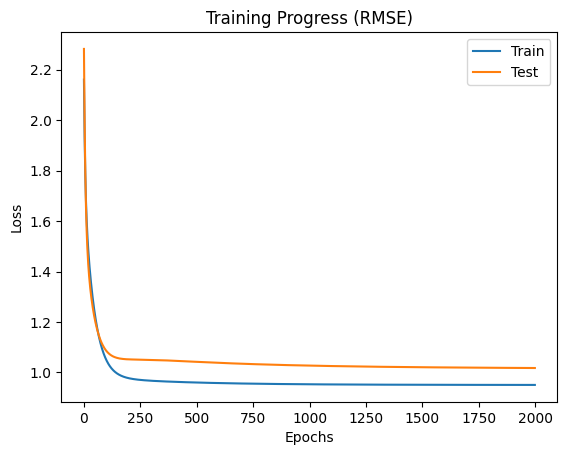

Fold 1 RMSE: 1.0358528484525091


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


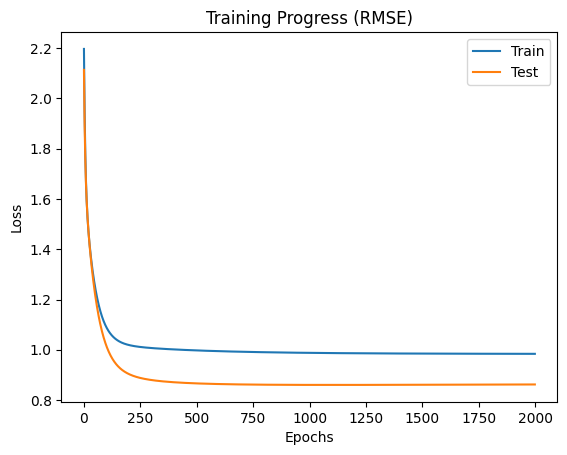

Fold 2 RMSE: 0.7431444040623135


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


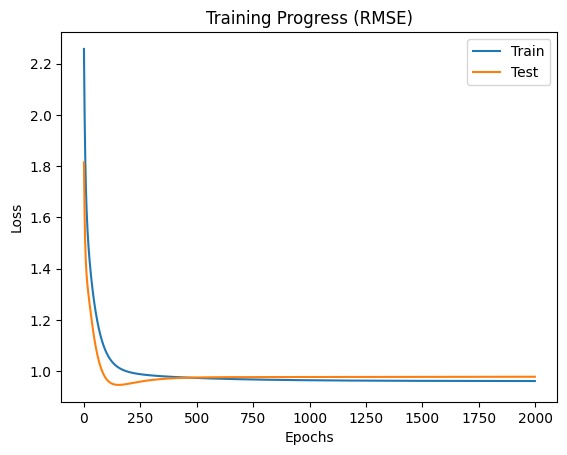

Fold 3 RMSE: 0.956526028517623


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


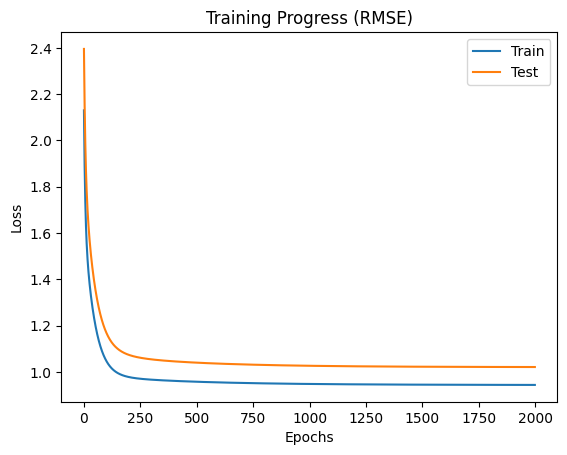

Fold 4 RMSE: 1.0438865777602047


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:41:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


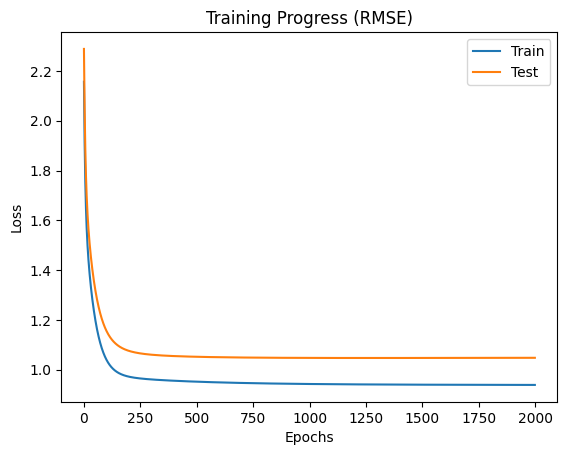

Fold 5 RMSE: 1.097243328903003
CV RMSE: 0.9753306375391307


In [24]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
preds = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]

    eval_set = [(X_train, y_train), (X_val, y_val)]

    model = xgb.XGBRegressor(
        n_estimators=2000,
        booster="gblinear",
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric=["rmse"], 
        objective="reg:linear"
    )

    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds)
    rmse_scores.append(rmse)
    #plot_importance(model, importance_type='gain')
    #plt.show()
    results = model.evals_result()

    plt.plot(results['validation_0']['rmse'], label='Train')
    plt.plot(results['validation_1']['rmse'], label='Test')
    plt.title('Training Progress (RMSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"Fold {fold+1} RMSE:", rmse)
    model.save_model(f"fidelity_model_fold_{fold}.json")

print("CV RMSE:", np.mean(rmse_scores))